# HMM Для прогнозирования

Для повышения точности прогнозов важно понимать, что разные модели прогнозирования подходят для разных временных рядов с разными характеристиками.

К сожалению, нет одной модели, которая бы подошла для расчета прогноза для всех ситуаций - типов временных рядов

Какие характеристики временных рядов можно выделить:

1. Сезонность:

   Полные ряды – когда данные есть минимум за 1 полный цикл, т.е. минимум за 12 месяцев, или за 4 квартала и можно выделить        сезонность;

   Неполный ряд – когда данных еще нет за полный цикл;
   

2. Рост:

    Временной ряд с ростом, когда можно выделить явный рост продаж от года к году.

      Рост может быть постоянный;

      Рост может быть затухающий;

      Рост может быть экспоненциальный;

      Рост может меняться падением;

     Статичный временной ряд – это временной ряд, который не содержит роста;
     

3. Важность тенденций для прогноза:

     Для прогноза могут быть важны тенденции за длительный период;

      Для прогноза могут быть важны тенденции за последний период;
      

4. Не регулярные, разовые продажи.


У нас есть набор различных параметров временных рядов. Данные параметры для одного временного ряда будут сочетаться между собой. Например,

        Временной ряд может быть полный с ростом и тенденциями за длительный период;

        Временной ряд может быть полный статичный с тенденциями за последний период;

        неполный с ростом и тенденциями за последний период.
        
        
При описании временных рядов регрессионными моделями обычно предполагается, что параметры моделей не изменяются на интервале наблюдения. Вместе с тем, например, экономические временные ряды часто демонстрируют нестационарное поведение, которое может быть обусловлено экономическими спадами, финансовыми кризисами, технологическими изменениями, положительными и отрицательными новостями и другими событиями. 

Если изменения
происходят в случайные моменты времени, то для адекватного описания могут быть использованы модели со скачкообразными изменениями параметров и с переключениями режимов работы


HMMlearn - библиотека с открытым исходным кодом, которая состоит из простых алгоритмов и моделей для изучения скрытых марковских моделей (HMM) в Python



http://scikit-learn.sourceforge.net/stable/modules/hmm.html

In [1]:
pip install hmmlearn

     |████████████████████████████████| 120 kB 569 kB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline
sns.set()

# Модели временных рядов с переключениями

Обозначим $s_t$ ненаблюдаемую переменную состояния, принимающую значения 0 или 1. Простейшая модель переключения для переменной $z_t$ состоит из двух спецификаций типа AR:

$z_t = \begin{cases} \alpha_0 + \beta z_{t-1} + \epsilon_t, & s_t = 0 \\ \alpha_0 + \alpha_1 + \beta z_{t-1} + \epsilon_t, & s_t = 1 \end{cases}$
 
где $|\beta|<1$ и $\epsilon_t$ независимые одинаково распределённые случайные величины с нулевым средним и дисперсией $\sigma^2_\epsilon$.

In [3]:
eps = np.random.normal(size=100)
alpha_0 = 0.
alpha_1 = 1.
beta = .05
s = np.random.binomial(n=1, p=0.8, size=100)
z1 = alpha_0 + beta * eps
z2 = alpha_0 + alpha_1 + beta * eps

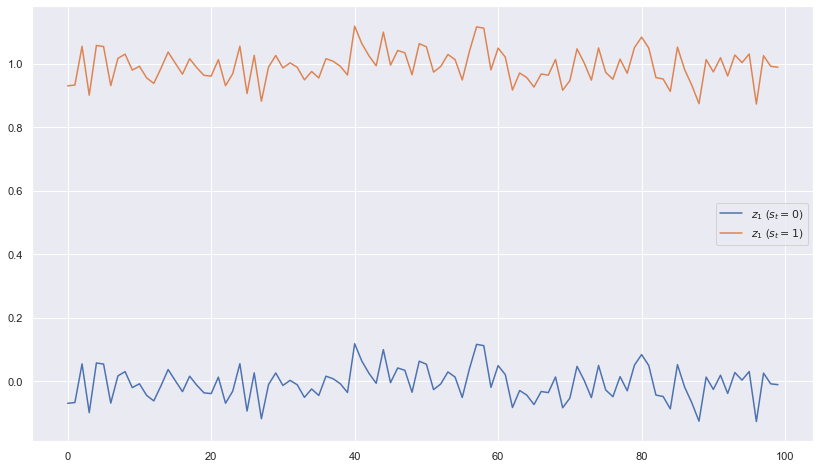

In [4]:
plt.figure(figsize=(14,8))
plt.plot(z1, label='$z_1$ ($s_t = 0$)')
plt.plot(z2, label='$z_1$ ($s_t = 1$)')
plt.legend()
plt.show()

In [5]:

z = []
for t, s_t in enumerate(s):
    if s_t == 0:
        z.append(z1[t])
    else:
        z.append(z2[t])

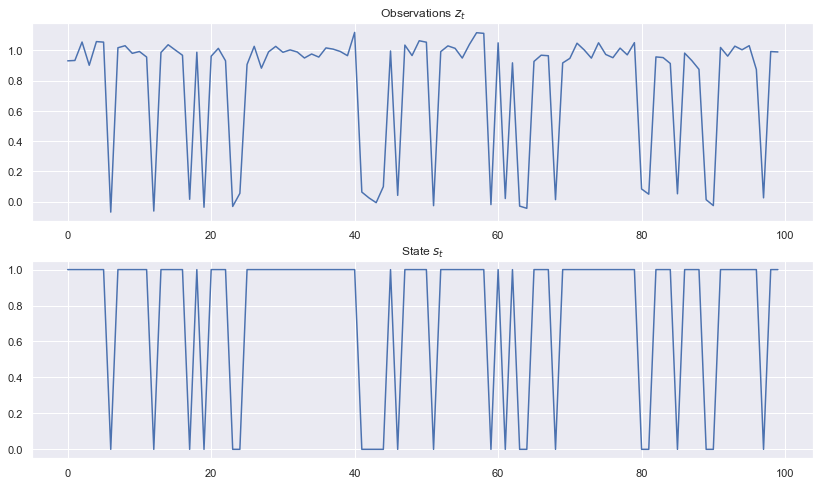

In [6]:
f, axs = plt.subplots(nrows=2, ncols=1, figsize=(14, 8))
axs[0].plot(z)
axs[0].set_title('Observations $z_t$')
axs[1].plot(s)
axs[1].set_title('State $s_t$')
plt.show()

Это стационарный AR(1) процесс со средним $\dfrac{\alpha_0}{1-\beta}$ при $s_t=0$ и переключающийся на другой стационарный AR(1) процесс со средним $\dfrac{\alpha_0+\alpha_1}{1-\beta}$, когда $s_t$ переключается с 0 на 1.

- если $a_1 \ne 0$: два динамических паттерна в зависимости от значения переменной состояния $s_t$;
- в этом случае $z_t$ управляется двумя распределениями с разным средним;
- переменная $s_t$ отвечает за переключение между этими распределениями (режимами).

Только что показанный пример: $s_t \sim Bern(p),p=0.8$.

В этой модели $s_t$ не зависит от предыдущих и будущих реализаций, поэтому $z_t$ может сильно "прыгать" (часто переключаться между разными состояниями).

## Что такое модель с марковским переключением?

Пусть, как раньше,

$z_t = \begin{cases} \alpha_0 + \beta z_{t-1} + \epsilon_t, & s_t = 0 \\ \alpha_0 + \alpha_1 + \beta z_{t-1} + \epsilon_t, & s_t = 1 \end{cases}$

Обозначим $s_t$ ненаблюдаемую переменную состояния, принимающую значения 0 или 1 согласно марковской цепи первого порядка:

$P=\begin{pmatrix} P(s_t=0|s_{t-1}=0) & P(s_t=1|s_{t-1}=0 \\ P(s_t=0|s_{t-1}=1) & P(s_t=1|s_{t-1}=1 \end{pmatrix} = \begin{pmatrix} p_{00} & p_{01} \\ p_{10} & p_{11} \end{pmatrix}$

где за $p_{ij},i,j∈\{0,1\}$ обозначена вероятность перехода в состояние $s_t=j$ из состояния $s_{i−1}=i$.

- Матрица перехода управляет случайным поведением переменной состояния и зависит только от двух параметров ($p00$
 и $p11$).
- Модель такого типа называют моделью с марковскими переключениями.
- Свойства $z_t$ определяются характеристиками распределения как $\epsilon_t$, так и переменной состояния $s_t$.
- В частности, марковская переменная состояния приводит к случайным и частым сменам режима, а вероятности перехода определяют персистентность каждого из режимов.

Важный факт: распределение наблюдений обусловлено ненаблюдаемой переменной состояния:
$Law(z_t)=Law(z_t|s_t)$

Например:
- $Law(z_t|s_t=0) = N(\dfrac{\alpha_0}{1-\beta}, \sigma_\epsilon^2)$
- $Law(z_t|s_t=1) = N(\dfrac{\alpha_0 + \alpha_1}{1-\beta}, \sigma_\epsilon^2)$

# Как сгенерировать траекторию модели с марковскими переключениями?

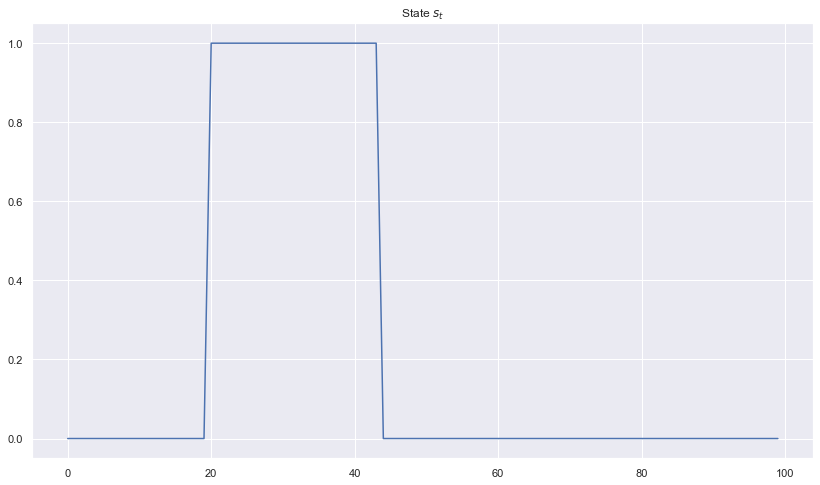

In [7]:
# 1. Генерирование марковской цепи с 2 скрытыми состояниями
P = np.array([
    [0.95, 0.05],
    [0.05, 0.95],
])
s = [0]
for t in range(99):
    distribution = P[s[-1]]
    s.append(np.random.choice([0, 1], p=distribution))

f, axs = plt.subplots(nrows=1, ncols=1, figsize=(14, 8))
axs.plot(s)
axs.set_title('State $s_t$')
plt.show()

In [8]:
# 2. Генерирование наблюдений из распределений, обусловленных ненаблюдаемым состоянием
eps = np.random.normal(size=100)
alpha_0 = 0.
alpha_1 = 1.
beta = .05
z1 = alpha_0 + beta * eps
z2 = alpha_0 + alpha_1 + beta * eps
z = []
for t, s_t in enumerate(s):
    if s_t == 0:
        z.append(z1[t])
    else:
        z.append(z2[t])

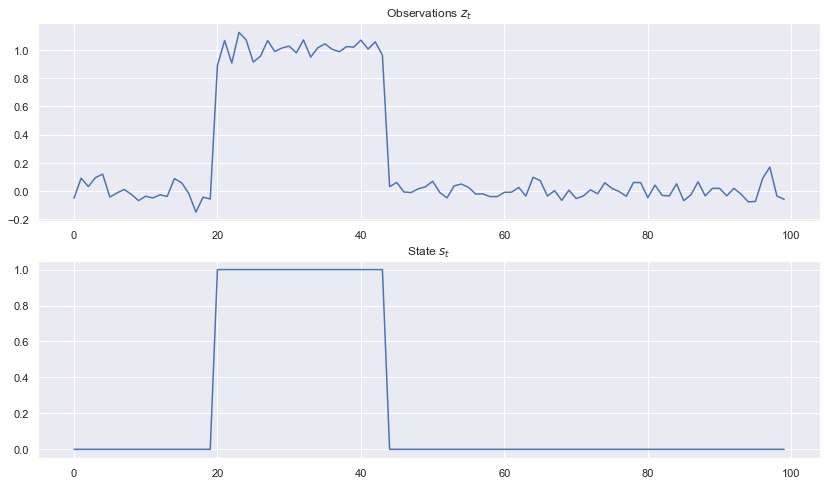

In [9]:
f, axs = plt.subplots(nrows=2, ncols=1, figsize=(14, 8))
axs[0].plot(z)
axs[0].set_title('Observations $z_t$')
axs[1].plot(s)
axs[1].set_title('State $s_t$')
plt.show()

Основные задачи теории скрытых марковских процессов:
    
- **Обучение с учителем**. Пусть есть некоторая последовательность $X$, для которой известны латентные переменные $T$. По обучающей выборке нужно оценить набор параметров $\Theta$.
- **Сегментация**. Пусть известна последовательность наблюдаемых переменных $X$ и набор параметров $\Theta$. По ним нужно построить максимально правдоподобный набор латентных переменных $T$, то есть найти $argmax_T p(T∣X,\Theta)$.
- **Обучение без учителя**. Пусть известна последовательность наблюдаемых переменных $X$ и число состояний $K$. Нужно оценить набор параметров $\Theta$. Подзадача - **нахождение маргинального распределения**: найти $p(t_n∣X,\Theta)$.
- **Прогнозирование**. Пусть известна некоторая последовательность X длины N. Нужно оценить наблюдаемый вектор в момент времени $N+1$, то есть найти $p(x_{N+1}∣X)$.

# Как сгенерировать траекторию скрытой марковской модели?

In [10]:
import numpy as np
from hmmlearn import hmm
np.random.seed(42)

model = hmm.GaussianHMM(n_components=3, covariance_type="full")
model.startprob_ = np.array([0.6, 0.3, 0.1])
model.transmat_ = np.array([[0.7, 0.2, 0.1],
                            [0.3, 0.5, 0.2],
                            [0.3, 0.3, 0.4]])
model.means_ = np.array([[0.0, 0.0], [3.0, -3.0], [5.0, 10.0]])
model.covars_ = np.tile(np.identity(2), (3, 1, 1))
X, Z = model.sample(100)

No handles with labels found to put in legend.


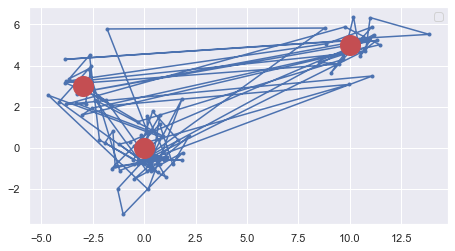

In [11]:
f, axs = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
_ = axs.plot(X[:, 1], X[:, 0], '.-')
_ = axs.plot(model.means_[:, 1], model.means_[:, 0], 'ro', ms=20)
_ = axs.legend()
axs.set_aspect('equal')

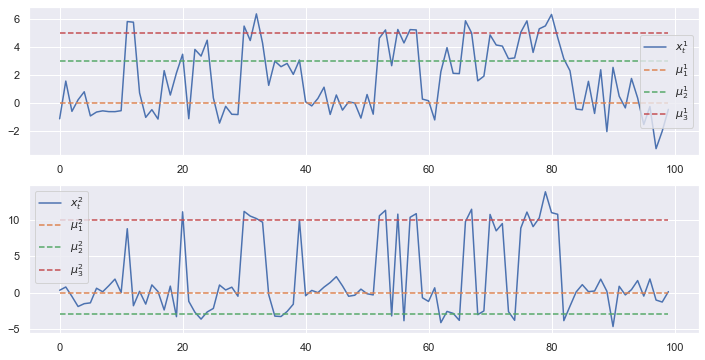

In [12]:
f, axs = plt.subplots(nrows=2, ncols=1, figsize=(12, 6))
_ = axs[0].plot(X[:, 0], label='$x^1_t$')
for i in range(3):
    _ = axs[0].plot(range(len(X)), model.means_[i, 0] * np.ones(len(X)), '--', label='$\mu^1_{}$'.format(i+1))
_ = axs[0].legend()

_ = axs[1].plot(X[:, 1], label='$x^2_t$')
for i in range(3):
    _ = axs[1].plot(range(len(X)), model.means_[i, 1] * np.ones(len(X)), '--', label='$\mu^2_{}$'.format(i+1))
_ = axs[1].legend()

# Прогноз с использованием HMM

Загрузка скрытого гауссовского класса модели Маркова

In [13]:
from hmmlearn.hmm import GaussianHMM

In [22]:
series = data = pd.read_csv('zp.csv', ';')['WAG_C_M']

In [23]:
series

0         15.3
1         19.1
2         23.6
3         30.6
4         37.5
        ...   
314    46324.0
315    48030.0
316    47926.0
317    49348.0
318    45900.0
Name: WAG_C_M, Length: 319, dtype: float64

In [24]:
values = series.values.reshape(-1,1)

In [25]:
values

array([[1.5300e+01],
       [1.9100e+01],
       [2.3600e+01],
       [3.0600e+01],
       [3.7500e+01],
       [4.7400e+01],
       [5.6000e+01],
       [6.5400e+01],
       [8.0900e+01],
       [9.3000e+01],
       [1.0150e+02],
       [1.4120e+02],
       [1.3420e+02],
       [1.4470e+02],
       [1.6480e+02],
       [1.7150e+02],
       [1.8350e+02],
       [2.0750e+02],
       [2.2100e+02],
       [2.3280e+02],
       [2.5320e+02],
       [2.6500e+02],
       [2.8160e+02],
       [3.5420e+02],
       [3.0260e+02],
       [3.2100e+02],
       [3.6150e+02],
       [3.8620e+02],
       [4.2990e+02],
       [4.8060e+02],
       [4.9950e+02],
       [5.2060e+02],
       [5.6450e+02],
       [5.9450e+02],
       [6.1570e+02],
       [7.3550e+02],
       [6.5480e+02],
       [6.8440e+02],
       [7.4500e+02],
       [7.4650e+02],
       [7.7930e+02],
       [8.3720e+02],
       [8.4280e+02],
       [8.3100e+02],
       [8.4810e+02],
       [8.4330e+02],
       [8.3500e+02],
       [1.017

Cоздадим  и обучим гауссовский HMM. Функция этого класса требует в качестве входных данных число скрытых состояний, число итераций для запуска из алгоритма Baum-Welch

Первым шагом в прогнозировании является обучение HMM для вычисления параметров из данной последовательности наблюдений. 
Как найти оптимальное количество скрытых состояний?

In [27]:
for n in range(1, 14):
    model = GaussianHMM(n_components=n,
                        
                        n_iter=1000)
    model.fit(values)
    print (n, model.score(values))

1 -3514.1425138246377
2 -3197.6436487869705
3 -3039.131831776589
4 -2947.9223630151164
5 -2907.7047228027004
6 -2852.6271177163385
7 -2827.455064341548
8 -2787.671081086682
9 -2778.3955816412517
10 -2750.2454911498376
11 -2738.463242219409
12 -2733.8617677436127
13 -2667.849953344259


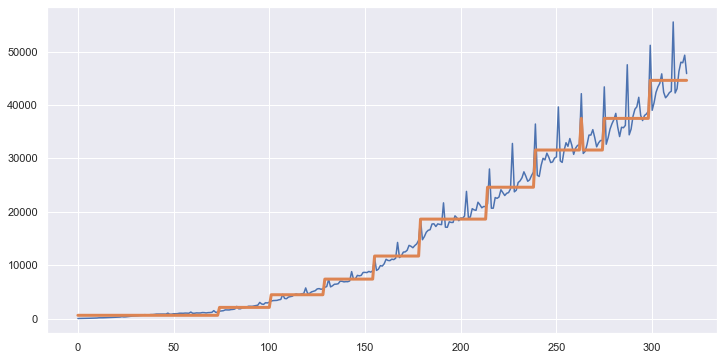

In [28]:
model = GaussianHMM(n_components=10,
                        covariance_type="diag",
                        n_iter=1000)
model.fit(values)
labels = model.predict(values)
means = np.zeros_like(values)
for i in range(model.n_components):
    means[labels == i] = model.means_[i]
    
plt.figure(figsize=(12, 6))
plt.plot(values)
plt.plot(means, linewidth=3)

In [29]:
model.transmat_.shape

(10, 10)

In [30]:
print(model.transmat_)

[[8.96769551e-001 0.00000000e+000 1.61127457e-118 0.00000000e+000
  6.53864911e-002 0.00000000e+000 0.00000000e+000 4.85310865e-025
  0.00000000e+000 3.78439582e-002]
 [0.00000000e+000 9.64323900e-001 0.00000000e+000 0.00000000e+000
  0.00000000e+000 9.88804868e-035 0.00000000e+000 0.00000000e+000
  3.56761005e-002 0.00000000e+000]
 [6.07744882e-161 0.00000000e+000 9.71097611e-001 4.65255163e-146
  2.45908914e-056 0.00000000e+000 8.41722034e-048 2.89023893e-002
  4.11489605e-300 6.02876023e-302]
 [0.00000000e+000 1.34284536e-128 0.00000000e+000 9.60210777e-001
  0.00000000e+000 1.57578652e-260 3.97892233e-002 0.00000000e+000
  4.69842829e-039 0.00000000e+000]
 [8.12913823e-002 0.00000000e+000 1.22134414e-059 0.00000000e+000
  9.18707807e-001 0.00000000e+000 4.75429970e-216 8.10243934e-007
  0.00000000e+000 3.18747688e-034]
 [0.00000000e+000 1.37744678e-002 0.00000000e+000 0.00000000e+000
  0.00000000e+000 9.86225532e-001 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000